In [1]:
import os
import numpy as np
import pandas as pd
import keras.backend as K
import pickle
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from keras.layers import Input, Lambda
from keras.models import Model, load_model, Sequential
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow as tf

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss, yolo_head, yolo_correct_boxes
from yolo3.utils import get_random_data, letterbox_image

C:\Users\Anti\Anaconda3\envs\ml\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Generate annotations file

In [2]:
def load_obj(name, path):
    with open(path + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [3]:
faces_path = '../face_detection/'

In [4]:
face_coordinates_per_video = load_obj('face_coordinates_per_video', faces_path)

In [5]:
face_coordinates_per_video['wrvlvrtarm.mp4']

{'0_0': {'coordinates': {'x1': 883, 'y1': 184, 'width': 88, 'height': 110},
  'keypoints': {'left_eye': (895, 220),
   'right_eye': (927, 215),
   'nose': (896, 241),
   'mouth_left': (898, 272),
   'mouth_right': (923, 268)},
  'confidence': 0.9997058510780334},
 '0_1': {'coordinates': {'x1': 437, 'y1': 221, 'width': 101, 'height': 142},
  'keypoints': {'left_eye': (499, 271),
   'right_eye': (527, 265),
   'nose': (535, 295),
   'mouth_left': (504, 325),
   'mouth_right': (530, 322)},
  'confidence': 0.9992200136184692},
 '75_0': {'coordinates': {'x1': 962, 'y1': 209, 'width': 90, 'height': 115},
  'keypoints': {'left_eye': (984, 245),
   'right_eye': (1020, 239),
   'nose': (994, 265),
   'mouth_left': (991, 296),
   'mouth_right': (1021, 292)},
  'confidence': 0.9998145699501038},
 '75_1': {'coordinates': {'x1': 521, 'y1': 245, 'width': 100, 'height': 144},
  'keypoints': {'left_eye': (584, 298),
   'right_eye': (608, 292),
   'nose': (618, 323),
   'mouth_left': (587, 353),
   'mo

In [6]:
annotations = {}
for key in face_coordinates_per_video.keys():
    file_name = key.split('.')[0]
    faces = face_coordinates_per_video[key]
    for frame_nr in np.unique([x.split('_')[0] for x in faces.keys()]):
        path = os.path.join(faces_path, '{}_{}.png'.format(file_name, frame_nr))
        keys = [x for x in faces.keys() if (frame_nr in x.split('_')[0]) and (len(frame_nr) == len(x.split('_')[0]))]
        annotations[path] = [faces[x] for x in keys]
#     for face_key in faces.keys():
#         path = os.path.join(faces_path, '{}.png'.format(file_name))

In [7]:
training_file = []
for key in annotations.keys():
    # key = '../face_detection/wrvlvrtarm_0.png'
    img_detections = annotations[key]
    detection_line = ''
    for detection in img_detections:
        c = detection['coordinates']
        additional_space = '' if len(detection_line) == 0 else ' '
        d = '{}{},{},{},{},0'.format(additional_space, \
                                      c['x1'], \
                                      c['y1'], \
                                      str(int(c['x1']) + int(c['height'])),\
                                      str(int(c['y1']) + int(c['width'])))
        detection_line = detection_line + d
    training_file.append([key, detection_line])

In [8]:
lines = [' '.join(x) for x in training_file]

In [9]:
# pd.DataFrame(training_file).to_csv('test.csv', sep=' ', header=False, index=False)

## Build model and train

### Train

In [10]:
def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)

In [11]:
annotation_path = 'train.txt'
log_dir = 'logs/000/'
classes_path = 'model_data/face_classes.txt'
anchors_path = 'model_data/tiny_yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)
input_shape = (416,416) # multiple of 32, hw

In [12]:
def create_tiny_model(input_shape, anchors, num_classes, load_pretrained=True, freeze_body=2,
            weights_path='model_data/tiny_yolo_weights.h5'):
    '''create the training model, for Tiny YOLOv3'''
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16}[l], w//{0:32, 1:16}[l], \
        num_anchors//2, num_classes+5)) for l in range(2)]

    model_body = tiny_yolo_body(image_input, num_anchors//2, num_classes)
    print('Create Tiny YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze the darknet body or freeze all but 2 output layers.
            num = (20, len(model_body.layers)-2)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.7})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model

In [13]:
model = create_tiny_model(input_shape, anchors, num_classes, load_pretrained=False,
            freeze_body=2)

Create Tiny YOLOv3 model with 6 anchors and 1 classes.


In [14]:
# logging = TensorBoard(log_dir=log_dir)
checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
    monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

In [15]:
def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes):
    '''data generator for fit_generator'''
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, random=True)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], np.zeros(batch_size)

def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes)

In [16]:
val_split = 0.1
np.random.seed(10101)
np.random.shuffle(lines)
np.random.seed(None)
num_val = int(len(lines)*val_split)
num_train = len(lines) - num_val

In [17]:
for i in range(len(model.layers)):
    model.layers[i].trainable = True
model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
print('Unfreeze all of the layers.')

Unfreeze all of the layers.


In [18]:
model.load_weights('tiny-yolov3.h5', by_name=True)

In [19]:
batch_size = 32 # note that more GPU memory is required after unfreezing the body
print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
    steps_per_epoch=max(1, num_train//batch_size),
    validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
    validation_steps=max(1, num_val//batch_size),
    epochs=100,
    initial_epoch=0,
    callbacks=[checkpoint, reduce_lr, early_stopping])

Train on 47997 samples, val on 5333 samples, with batch size 32.
Epoch 1/100
1499/1499 [==============================] - 7361s 5s/step - loss: 4.9452 - val_loss: 5.4359
Epoch 2/100
1499/1499 [==============================] - 7296s 5s/step - loss: 4.7475 - val_loss: 4.8891
Epoch 3/100
1499/1499 [==============================] - 7289s 5s/step - loss: 4.6375 - val_loss: 5.0299
Epoch 4/100
1499/1499 [==============================] - 7204s 5s/step - loss: 4.4973 - val_loss: 4.4726
Epoch 5/100
  12/1499 [..............................] - ETA: 10:14 - loss: 4.4386

KeyboardInterrupt: 

In [19]:
batch_size = 32 # note that more GPU memory is required after unfreezing the body
print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
    steps_per_epoch=max(1, num_train//batch_size),
    validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
    validation_steps=max(1, num_val//batch_size),
    epochs=100,
    initial_epoch=0,
    callbacks=[checkpoint, reduce_lr, early_stopping])

Train on 47997 samples, val on 5333 samples, with batch size 32.
Epoch 1/100
1499/1499 [==============================] - 6948s 5s/step - loss: 6.8163 - val_loss: 6.3364
Epoch 2/100
1499/1499 [==============================] - 6858s 5s/step - loss: 6.0349 - val_loss: 6.0053
Epoch 3/100
1499/1499 [==============================] - 6894s 5s/step - loss: 5.5713 - val_loss: 5.8492
Epoch 4/100
1499/1499 [==============================] - 6867s 5s/step - loss: 5.2414 - val_loss: 4.8183
Epoch 5/100
 738/1499 [=============>................] - ETA: 47:31 - loss: 5.0780

KeyboardInterrupt: 

In [19]:
batch_size = 32 # note that more GPU memory is required after unfreezing the body
print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
    steps_per_epoch=max(1, num_train//batch_size),
    validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
    validation_steps=max(1, num_val//batch_size),
    epochs=100,
    initial_epoch=0,
    callbacks=[checkpoint, reduce_lr, early_stopping])

Train on 47997 samples, val on 5333 samples, with batch size 32.
Epoch 1/100
1499/1499 [==============================] - 7595s 5s/step - loss: 56.0141 - val_loss: 20.1968
Epoch 2/100
1499/1499 [==============================] - 6686s 4s/step - loss: 14.6628 - val_loss: 11.9098
Epoch 3/100
1499/1499 [==============================] - 6652s 4s/step - loss: 9.7116 - val_loss: 9.1515
Epoch 4/100
 869/1499 [================>.............] - ETA: 4:32:23 - loss: 7.9760

KeyboardInterrupt: 

In [20]:
model.save('tiny-yolov3.h5')

In [20]:
model.save_weights('tiny-yolov3.weights')

### Get rid of last layer

In [19]:
def create_tiny_model(input_shape, anchors, num_classes, load_pretrained=True, freeze_body=2,
            weights_path='model_data/tiny_yolo_weights.h5'):
    '''create the training model, for Tiny YOLOv3'''
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16}[l], w//{0:32, 1:16}[l], \
        num_anchors//2, num_classes+5)) for l in range(2)]

    model_body = tiny_yolo_body(image_input, num_anchors//2, num_classes)
    print('Create Tiny YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze the darknet body or freeze all but 2 output layers.
            num = (20, len(model_body.layers)-2)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

#     model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
#         arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.7})(
#         [*model_body.output, *y_true])
    model = Model([model_body.input], [*model_body.output])

    return model

In [20]:
model = create_tiny_model(input_shape, anchors, num_classes, load_pretrained=False,
            freeze_body=2)

Create Tiny YOLOv3 model with 6 anchors and 1 classes.


In [21]:
model.compile(optimizer=Adam(lr=1e-4))

C:\Users\Anti\Anaconda3\envs\ml\lib\site-packages\keras\engine\training_utils.py:819: UserWarning: Output conv2d_10 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to conv2d_10.
  'be expecting any data to be passed to {0}.'.format(name))
C:\Users\Anti\Anaconda3\envs\ml\lib\site-packages\keras\engine\training_utils.py:819: UserWarning: Output conv2d_13 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to conv2d_13.
  'be expecting any data to be passed to {0}.'.format(name))


In [22]:
model.load_weights('tiny-yolov3.h5', by_name=True)

In [23]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 1 432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 1 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, None, None, 1 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [24]:
lines[:num_train]

['../face_detection/znrixntqqb_0.png 975,309,1164,458,0',
 '../face_detection/rpwjfquqal_75.png 858,393,1072,547,0',
 '../face_detection/wczgyxmjnt_150.png 721,276,1214,668,0',
 '../face_detection/tcarsvtmlc_150.png 902,485,1028,579,0',
 '../face_detection/rylynffzhh_0.png 672,158,846,312,0',
 '../face_detection/tvpnmwpkcx_0.png 753,230,988,406,0',
 '../face_detection/otfewufpsw_0.png 413,394,502,468,0',
 '../face_detection/szkodmxxtz_0.png 841,82,1008,202,0',
 '../face_detection/lqkyroubqx_75.png 675,155,868,306,0',
 '../face_detection/twenwjpqvo_75.png 781,255,1009,405,0',
 '../face_detection/qqxohuaupb_0.png 895,284,1095,452,0',
 '../face_detection/gbwgfjfwax_75.png 692,450,878,574,0 1275,424,1451,559,0',
 '../face_detection/ijvqpzanqe_0.png 897,458,1030,558,0',
 '../face_detection/pojvzwdlwd_75.png 791,515,983,657,0',
 '../face_detection/dljegkgcan_75.png 647,491,817,616,0 1221,207,1411,357,0',
 '../face_detection/yiooctyvit_0.png 952,313,1033,380,0',
 '../face_detection/czfqlbcfpa

In [25]:
lines[:1]

['../face_detection/znrixntqqb_0.png 975,309,1164,458,0']

In [26]:
idx = 0
for x, y in data_generator_wrapper(lines[:num_train], 1, input_shape, anchors, num_classes):
    idx += 1
    if idx > 0:
        break

In [27]:
x[0].shape

(1, 416, 416, 3)

In [28]:
x[1].shape

(1, 13, 13, 3, 6)

In [29]:
x[2].shape

(1, 26, 26, 3, 6)

In [30]:
img = Image.open('../face_detection/znrixntqqb_0.png')

In [31]:
boxed_image = letterbox_image(img, (416,416))

In [32]:
image_data = np.array(boxed_image, dtype='float32')

In [33]:
image_data /= 255.
image_data = np.expand_dims(image_data, 0) 

In [34]:
pred = model.predict(image_data)
pred

[array([[[[-4.33202356e-01, -3.14866245e-01,  8.05194378e-02, ...,
            1.28651108e-03, -1.34121008e+01,  1.22602880e+00],
          [-6.32266581e-01, -9.82266903e-01,  1.68750763e-01, ...,
           -4.53422591e-02, -1.38912964e+01,  1.52211189e+00],
          [-2.38091558e-01, -8.88163447e-01,  1.90824598e-01, ...,
           -5.72593808e-02, -1.40403900e+01,  1.56430185e+00],
          ...,
          [-3.53866488e-01, -1.18397212e+00,  2.43706271e-01, ...,
           -1.00950435e-01, -1.43914499e+01,  1.80051422e+00],
          [-3.50506574e-01, -1.11416805e+00,  1.14033826e-01, ...,
           -1.06429085e-01, -1.46077070e+01,  1.82597685e+00],
          [-8.33565444e-02, -8.38000417e-01, -5.63848913e-01, ...,
           -4.25685048e-02, -1.38265724e+01,  1.55744076e+00]],
 
         [[-2.28478372e-01, -8.37853253e-02, -1.14372410e-01, ...,
           -8.60873237e-03, -1.28828554e+01,  1.31421709e+00],
          [-1.31293535e-01, -4.32347238e-01,  6.76281527e-02, ...,
     

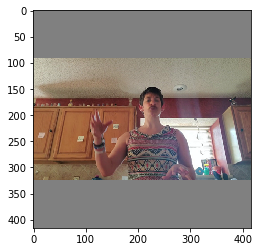

In [35]:
plt.imshow(boxed_image)

In [36]:
pred = model.predict(x)
pred

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 1 array(s), but instead got the following list of 3 arrays: [array([[[[0.36371215, 0.36371215, 0.36371215],
         [0.36371215, 0.36371215, 0.36371215],
         [0.36371215, 0.36371215, 0.36371215],
         ...,
         [0.36371215, 0.36371215, 0.36371215...

In [37]:
len(pred)

2

In [38]:
print(pred[0].shape)
print(pred[1].shape)
print(pred[2].shape)
print(pred[3].shape)

(1, 13, 13, 18)
(1, 26, 26, 18)


IndexError: list index out of range

In [39]:
num_layers = len(anchors)//3 # default setting
yolo_outputs = pred[:num_layers]
y_true = pred[num_layers:]
anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] if num_layers==3 else [[3,4,5], [1,2,3]]

In [40]:
for l in range(num_layers):
    input_shape = K.cast(K.shape(tf.convert_to_tensor(yolo_outputs[l]))[1:3] * 32, K.dtype(tf.convert_to_tensor(yolo_outputs[l])))
    # id_shapes = [K.cast(K.shape(tf.convert_to_tensor(yolo_outputs[l]))[1:3], K.dtype(tf.convert_to_tensor(y_true[0]))) for l in range(num_layers)]
    loss = 0
    m = K.shape(yolo_outputs[0])[0] # batch size, tensor
    mf = K.cast(m, K.dtype(tf.convert_to_tensor(yolo_outputs[0])))
#     object_mask = y_true[l][..., 4:5]
#     true_class_probs = y_true[l][..., 5:]

    grid, raw_pred, pred_xy, pred_wh = yolo_head(tf.convert_to_tensor(yolo_outputs[l]),
         anchors[anchor_mask[l]], num_classes, input_shape, calc_loss=True)
    pred_box = K.concatenate([pred_xy, pred_wh])
#     break

In [41]:
grid

<tf.Tensor: id=5249, shape=(26, 26, 1, 2), dtype=float32, numpy=
array([[[[ 0.,  0.]],

        [[ 1.,  0.]],

        [[ 2.,  0.]],

        ...,

        [[23.,  0.]],

        [[24.,  0.]],

        [[25.,  0.]]],


       [[[ 0.,  1.]],

        [[ 1.,  1.]],

        [[ 2.,  1.]],

        ...,

        [[23.,  1.]],

        [[24.,  1.]],

        [[25.,  1.]]],


       [[[ 0.,  2.]],

        [[ 1.,  2.]],

        [[ 2.,  2.]],

        ...,

        [[23.,  2.]],

        [[24.,  2.]],

        [[25.,  2.]]],


       ...,


       [[[ 0., 23.]],

        [[ 1., 23.]],

        [[ 2., 23.]],

        ...,

        [[23., 23.]],

        [[24., 23.]],

        [[25., 23.]]],


       [[[ 0., 24.]],

        [[ 1., 24.]],

        [[ 2., 24.]],

        ...,

        [[23., 24.]],

        [[24., 24.]],

        [[25., 24.]]],


       [[[ 0., 25.]],

        [[ 1., 25.]],

        [[ 2., 25.]],

        ...,

        [[23., 25.]],

        [[24., 25.]],

        [[25., 25.]]]]

In [42]:
for l in range(num_layers):
    print(l)

0
1


In [43]:
yolo_outputs[1].shape

(1, 26, 26, 18)

In [44]:
box_xy, box_wh, box_confidence, box_class_probs = yolo_head(tf.convert_to_tensor(yolo_outputs[l]),
     anchors[anchor_mask[l]], num_classes, input_shape)

In [45]:
boxes = yolo_correct_boxes(box_xy, box_wh, input_shape, (416, 416))
boxes = K.reshape(boxes, [-1, 4])
box_scores = box_confidence * box_class_probs
box_scores = K.reshape(box_scores, [-1, num_classes])

In [46]:
boxes.numpy()

array([[  0.5490955,  -0.5218774,  13.97112  ,   9.636215 ],
       [ -6.704591 ,   1.3206166,  21.241096 ,  12.588551 ],
       [ -4.542725 , -16.252121 ,  19.92915  ,  25.031685 ],
       ...,
       [398.51663  , 405.0651   , 417.60312  , 411.4443   ],
       [380.65335  , 404.18695  , 430.9723   , 412.50537  ],
       [389.14987  , 389.78598  , 429.19916  , 421.6573   ]],
      dtype=float32)

In [47]:
box_scores = box_confidence * box_class_probs
box_scores = K.reshape(box_scores, [-1, num_classes])

In [48]:
box_scores.numpy()

array([[1.3443485e-05],
       [7.0205901e-06],
       [3.3100841e-06],
       ...,
       [6.0112493e-06],
       [3.0306880e-06],
       [1.2141149e-06]], dtype=float32)

In [49]:
np.argwhere(box_scores.numpy()>0.1)[:, :1]

array([[822],
       [823],
       [901]], dtype=int64)

In [50]:
box_scores.numpy()[np.argwhere(box_scores.numpy()>0.1)[:, :1]]

array([[[0.16123877]],

       [[0.90720034]],

       [[0.30429375]]], dtype=float32)

In [51]:
boxes.numpy()[np.argwhere(box_scores.numpy()>0.1)[:, :1]]

array([[[166.97975, 216.58035, 181.40291, 236.60353]],

       [[165.03624, 216.19621, 182.18805, 238.8812 ]],

       [[167.47894, 216.7625 , 186.43332, 238.43726]]], dtype=float32)

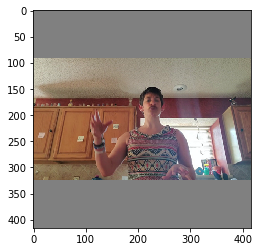

In [52]:
plt.imshow(boxed_image)

In [53]:
temp = cv2.resize(np.array(boxed_image, dtype='float32'), dsize=(1920, 1080), interpolation=cv2.INTER_CUBIC)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


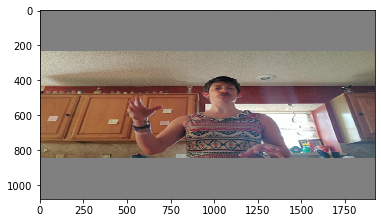

In [59]:
plt.imshow(temp.astype(np.int16))

In [45]:
np.array(boxed_image, dtype='float32')

array([[[128., 128., 128.],
        [128., 128., 128.],
        [128., 128., 128.],
        ...,
        [128., 128., 128.],
        [128., 128., 128.],
        [128., 128., 128.]],

       [[128., 128., 128.],
        [128., 128., 128.],
        [128., 128., 128.],
        ...,
        [128., 128., 128.],
        [128., 128., 128.],
        [128., 128., 128.]],

       [[128., 128., 128.],
        [128., 128., 128.],
        [128., 128., 128.],
        ...,
        [128., 128., 128.],
        [128., 128., 128.],
        [128., 128., 128.]],

       ...,

       [[128., 128., 128.],
        [128., 128., 128.],
        [128., 128., 128.],
        ...,
        [128., 128., 128.],
        [128., 128., 128.],
        [128., 128., 128.]],

       [[128., 128., 128.],
        [128., 128., 128.],
        [128., 128., 128.],
        ...,
        [128., 128., 128.],
        [128., 128., 128.],
        [128., 128., 128.]],

       [[128., 128., 128.],
        [128., 128., 128.],
        [128., 1

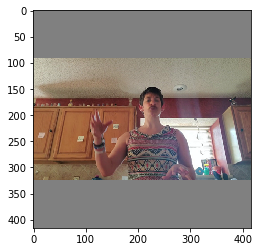

In [43]:
plt.imshow(boxed_image)

In [42]:
lines[:num_train]

['../face_detection/znrixntqqb_0.png 975,309,1164,458,0',
 '../face_detection/rpwjfquqal_75.png 858,393,1072,547,0',
 '../face_detection/wczgyxmjnt_150.png 721,276,1214,668,0',
 '../face_detection/tcarsvtmlc_150.png 902,485,1028,579,0',
 '../face_detection/rylynffzhh_0.png 672,158,846,312,0',
 '../face_detection/tvpnmwpkcx_0.png 753,230,988,406,0',
 '../face_detection/otfewufpsw_0.png 413,394,502,468,0',
 '../face_detection/szkodmxxtz_0.png 841,82,1008,202,0',
 '../face_detection/lqkyroubqx_75.png 675,155,868,306,0',
 '../face_detection/twenwjpqvo_75.png 781,255,1009,405,0',
 '../face_detection/qqxohuaupb_0.png 895,284,1095,452,0',
 '../face_detection/gbwgfjfwax_75.png 692,450,878,574,0 1275,424,1451,559,0',
 '../face_detection/ijvqpzanqe_0.png 897,458,1030,558,0',
 '../face_detection/pojvzwdlwd_75.png 791,515,983,657,0',
 '../face_detection/dljegkgcan_75.png 647,491,817,616,0 1221,207,1411,357,0',
 '../face_detection/yiooctyvit_0.png 952,313,1033,380,0',
 '../face_detection/czfqlbcfpa

In [174]:
box_xy.numpy().shape

(1, 26, 26, 3, 2)

In [175]:
box_wh.numpy().shape

(1, 26, 26, 3, 2)

In [104]:
for l in range(num_layers):
    object_mask = y_true[l][..., 4:5]
    true_class_probs = y_true[l][..., 5:]

    grid, raw_pred, pred_xy, pred_wh = yolo_head(tf.convert_to_tensor(y_true[l]),
         anchors[anchor_mask[l]], num_classes, input_shape, calc_loss=True)
    pred_box = K.concatenate([pred_xy, pred_wh])
    break

In [105]:
box_xy, box_wh, box_confidence, box_class_probs = yolo_head(tf.convert_to_tensor(y_true[l]),
     anchors[anchor_mask[l]], num_classes, input_shape)

In [106]:
boxes = yolo_correct_boxes(box_xy, box_wh, input_shape, (1920, 1080))
boxes = K.reshape(boxes, [-1, 4])
box_scores = box_confidence * box_class_probs
box_scores = K.reshape(box_scores, [-1, num_classes])

In [107]:
np.argwhere(box_scores.numpy()>0.1)[:, :1]

array([[  0],
       [  1],
       [  2],
       [  3],
       [  4],
       [  5],
       [  6],
       [  7],
       [  8],
       [  9],
       [ 10],
       [ 11],
       [ 12],
       [ 13],
       [ 14],
       [ 15],
       [ 16],
       [ 17],
       [ 18],
       [ 19],
       [ 20],
       [ 21],
       [ 22],
       [ 23],
       [ 24],
       [ 25],
       [ 26],
       [ 27],
       [ 28],
       [ 29],
       [ 30],
       [ 31],
       [ 32],
       [ 33],
       [ 34],
       [ 35],
       [ 36],
       [ 37],
       [ 38],
       [ 39],
       [ 40],
       [ 41],
       [ 42],
       [ 43],
       [ 44],
       [ 45],
       [ 46],
       [ 47],
       [ 48],
       [ 49],
       [ 50],
       [ 51],
       [ 52],
       [ 53],
       [ 54],
       [ 55],
       [ 56],
       [ 57],
       [ 58],
       [ 59],
       [ 60],
       [ 61],
       [ 62],
       [ 63],
       [ 64],
       [ 65],
       [ 66],
       [ 67],
       [ 68],
       [ 69],
       [ 70],
      

In [108]:
box_scores.numpy()[np.argwhere(box_scores.numpy()>0.3)[:, :1]]

array([[[0.53444666]]], dtype=float32)

In [109]:
boxes.numpy()[np.argwhere(box_scores.numpy()>0.3)[:, :1]]

array([[[1237.917 ,  442.4989, 2220.3804, 1573.4609]]], dtype=float32)

In [110]:
lines[:num_train]

['../face_detection/znrixntqqb_0.png 975,309,1164,458,0',
 '../face_detection/rpwjfquqal_75.png 858,393,1072,547,0',
 '../face_detection/wczgyxmjnt_150.png 721,276,1214,668,0',
 '../face_detection/tcarsvtmlc_150.png 902,485,1028,579,0',
 '../face_detection/rylynffzhh_0.png 672,158,846,312,0',
 '../face_detection/tvpnmwpkcx_0.png 753,230,988,406,0',
 '../face_detection/otfewufpsw_0.png 413,394,502,468,0',
 '../face_detection/szkodmxxtz_0.png 841,82,1008,202,0',
 '../face_detection/lqkyroubqx_75.png 675,155,868,306,0',
 '../face_detection/twenwjpqvo_75.png 781,255,1009,405,0',
 '../face_detection/qqxohuaupb_0.png 895,284,1095,452,0',
 '../face_detection/gbwgfjfwax_75.png 692,450,878,574,0 1275,424,1451,559,0',
 '../face_detection/ijvqpzanqe_0.png 897,458,1030,558,0',
 '../face_detection/pojvzwdlwd_75.png 791,515,983,657,0',
 '../face_detection/dljegkgcan_75.png 647,491,817,616,0 1221,207,1411,357,0',
 '../face_detection/yiooctyvit_0.png 952,313,1033,380,0',
 '../face_detection/czfqlbcfpa

In [59]:
import cv2

In [60]:
res = cv2.resize(x[0][0], dsize=(1920, 1080), interpolation=cv2.INTER_CUBIC)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


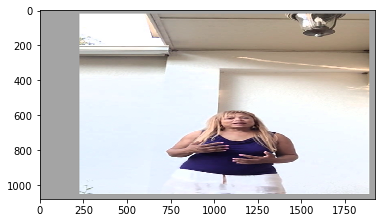

In [61]:
plt.imshow(res)

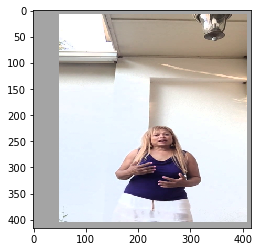

In [57]:
plt.imshow(x[0][0])

In [ ]:
[1071.0632 ,  660.55365, 1129.283  ,  779.4844 ]

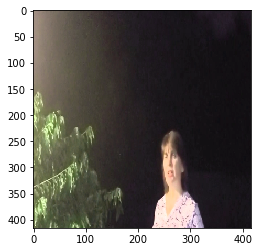

In [38]:
plt.imshow(x[0][8])

### Load YOLO

In [19]:
from PIL import Image

In [20]:
import importlib
import yolov3
from yolov3 import YOLO
importlib.reload(yolov3)
# yolo = YOLO(yolo_model=model)
yolo = YOLO()


tiny-yolov3.h5 model, anchors, and classes loaded.


In [21]:
img = Image.open('../face_detection/znrixntqqb_0.png')

In [22]:
res = yolo.detect_image(img)

(416, 416, 3)


TypeError: Tensor is unhashable if Tensor equality is enabled. Instead, use tensor.experimental_ref() as the key.

In [64]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)


Version:  2.0.0
Eager mode:  True


NameError: name 'hub' is not defined

In [ ]:
res

### Predict

In [21]:
model.output_shape

(None, 1)

In [22]:
model.compile(optimizer=Adam(lr=1e-4))

C:\Users\Anti\Anaconda3\envs\ml\lib\site-packages\keras\engine\training_utils.py:819: UserWarning: Output yolo_loss missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to yolo_loss.
  'be expecting any data to be passed to {0}.'.format(name))


In [22]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 1 432         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 1 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, None, None, 1 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [24]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/Anti/Anaconda3/envs/ml/Lib/site-packages/graphviz'

In [25]:
os.environ["PATH"]

'C:\\Users\\Anti\\Anaconda3\\envs\\ml\\lib\\site-packages\\pywin32_system32;C:\\Users\\Anti\\Anaconda3\\envs\\ml\\lib\\site-packages\\pywin32_system32;C:\\Users\\Anti\\Anaconda3\\envs\\ml;C:\\Users\\Anti\\Anaconda3\\envs\\ml\\Library\\mingw-w64\\bin;C:\\Users\\Anti\\Anaconda3\\envs\\ml\\Library\\usr\\bin;C:\\Users\\Anti\\Anaconda3\\envs\\ml\\Library\\bin;C:\\Users\\Anti\\Anaconda3\\envs\\ml\\Scripts;C:\\Users\\Anti\\Anaconda3\\envs\\ml\\bin;C:\\Users\\Anti\\Anaconda3\\condabin;C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v10.2\\bin;C:\\Program Files\\NVIDIA GPU Computing Toolkit\\CUDA\\v10.2\\libnvvp;C:\\ProgramData\\DockerDesktop\\version-bin;C:\\Program Files\\Docker\\Docker\\Resources\\bin;C:\\Windows\\system32;C:\\Windows;C:\\Windows\\System32\\Wbem;C:\\Windows\\System32\\WindowsPowerShell\\v1.0;C:\\Windows\\System32\\OpenSSH;C:\\Program Files (x86)\\NVIDIA Corporation\\PhysX\\Common;C:\\Program Files\\NVIDIA Corporation\\NVIDIA NvDLISR;C:\\Program Files\\Git\\cmd;C:\\Pro

In [26]:
os.pathsep + 'C:/Users/Anti/Anaconda3/envs/ml/Lib/site-packages/graphviz'

';C:/Users/Anti/Anaconda3/envs/ml/Lib/site-packages/graphviz'

In [48]:
model.layers

In [22]:
idx = 0
for x, y in data_generator_wrapper(lines[:num_train], 32, input_shape, anchors, num_classes):
    idx += 1
    if idx > 2:
        break

In [23]:
len(x)

3

In [24]:
x[0].shape

(32, 416, 416, 3)

In [25]:
x[1].shape

(32, 13, 13, 3, 6)

In [26]:
x[2].shape

(32, 26, 26, 3, 6)

In [27]:
np.unique(x[1])

array([0.        , 0.04807692, 0.08173077, 0.0889423 , 0.09615385,
       0.14903846, 0.1514423 , 0.15865384, 0.17067307, 0.17307693,
       0.18509616, 0.18990384, 0.19711539, 0.20192307, 0.20432693,
       0.20913461, 0.21875   , 0.2235577 , 0.22596154, 0.25      ,
       0.3125    , 0.33653846, 0.375     , 0.41105768, 0.44951922,
       0.45192307, 0.4783654 , 0.48076922, 0.5192308 , 0.55288464,
       0.6418269 , 0.68990386, 0.86538464, 1.        ], dtype=float32)

In [28]:
np.unique(x[2])

array([0.        , 0.03605769, 0.03846154, 0.04326923, 0.04567308,
       0.04807692, 0.05288462, 0.05769231, 0.06009615, 0.0625    ,
       0.06490385, 0.0673077 , 0.06971154, 0.07211538, 0.07451923,
       0.07692308, 0.08173077, 0.08413462, 0.08653846, 0.0889423 ,
       0.09134615, 0.09615385, 0.10336538, 0.10576923, 0.10817308,
       0.11538462, 0.1201923 , 0.12259615, 0.13221154, 0.13701923,
       0.13942307, 0.14663461, 0.14903846, 0.1514423 , 0.15384616,
       0.15865384, 0.1610577 , 0.16346154, 0.16586539, 0.17067307,
       0.17307693, 0.18028846, 0.18509616, 0.18990384, 0.19711539,
       0.20192307, 0.20432693, 0.20913461, 0.21875   , 0.22115384,
       0.2235577 , 0.22596154, 0.22836539, 0.23557693, 0.24038461,
       0.25      , 0.25480768, 0.27403846, 0.3125    , 0.33653846,
       0.33894232, 0.34615386, 0.35576922, 0.375     , 0.37980768,
       0.38701922, 0.39423078, 0.40384614, 0.40625   , 0.41105768,
       0.43269232, 0.4375    , 0.44951922, 0.45192307, 0.47836

In [29]:
x[2].shape

(32, 26, 26, 3, 6)

In [30]:
x[2][0]

array([[[[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        ...,

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]]],


       [[[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0.]],

        ...,

       

In [31]:
len(y)

32

In [36]:
pred = model.predict(x)
pred

array([7.271364, 7.271364, 7.271364, 7.271364, 7.271364, 7.271364,
       7.271364, 7.271364, 7.271364, 7.271364, 7.271364, 7.271364,
       7.271364, 7.271364, 7.271364, 7.271364, 7.271364, 7.271364,
       7.271364, 7.271364, 7.271364, 7.271364, 7.271364, 7.271364,
       7.271364, 7.271364, 7.271364, 7.271364, 7.271364, 7.271364,
       7.271364, 7.271364], dtype=float32)

In [40]:
pred = model.predict(x)

In [41]:
pred

array([5.7237024, 5.7237024, 5.7237024, 5.7237024, 5.7237024, 5.7237024,
       5.7237024, 5.7237024, 5.7237024, 5.7237024, 5.7237024, 5.7237024,
       5.7237024, 5.7237024, 5.7237024, 5.7237024, 5.7237024, 5.7237024,
       5.7237024, 5.7237024, 5.7237024, 5.7237024, 5.7237024, 5.7237024,
       5.7237024, 5.7237024, 5.7237024, 5.7237024, 5.7237024, 5.7237024,
       5.7237024, 5.7237024], dtype=float32)

In [41]:
y

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [50]:
def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes):
    '''data generator for fit_generator'''
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, random=True)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield y_true
        yield [image_data, *y_true], np.zeros(batch_size)

def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes)

In [51]:
for x, y in data_generator_wrapper(lines[:num_train], 32, input_shape, anchors, num_classes):
    break

In [53]:
x.shape

(32, 13, 13, 3, 6)

In [54]:
y.shape

(32, 26, 26, 3, 6)

In [56]:
y.max()

1.0

In [73]:
import importlib

In [79]:
import yolov3
from yolov3 import YOLO

In [83]:
importlib.reload(yolov3)
from yolov3 import YOLO
yolo = YOLO()

ValueError: Shapes (1, 1, 512, 255) and (18, 512, 1, 1) are incompatible